# Solve CartPole using DQN

https://gym.openai.com/envs/CartPole-v0/

Some useful resources:
  * https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/

In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import matplotlib.pyplot as plt
import gym

from agents import ReplayBuffer
from agents.dqn import QNetwork

from IPython.display import clear_output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore environment

Observation shape: (4,)
Number of actions: 2
Example state: [ 0.03819708 -0.0391353  -0.00089787 -0.01406345]


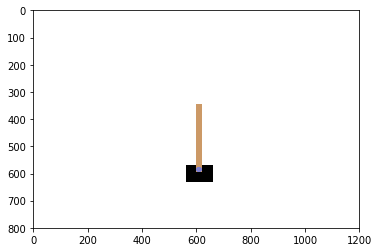

In [14]:
#spawn game instance for tests
env = gym.make("CartPole-v0") #create raw env

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape: {}".format(observation_shape))
print("Number of actions: {}".format(n_actions))

print("Example state: {}".format(env.reset()))
plt.imshow(env.render('rgb_array'))

# Build DQN Agent

## Build traing set

In [15]:
def build_training_set(qvalues, qvalues_next, actions, rewards, dones, gamma=0.99):
    """
    Create training set for QNetwork.
    Params:
      qvalues           - Q values for the starting state
      qvalues_next      - Q values for the state the next state
      actions           - Actions taken
      rewards           - Rewards received after taking action 
      dones             - Did this action end the episode?
      
    Returns:
      Expected qvalues
    """
    y = qvalues.copy()
    next_rewards = np.where(dones, np.zeros(rewards.shape), np.max(qvalues_next, axis=1))
    y[np.arange(y.shape[0]), actions] = rewards + gamma * next_rewards
    return y


# Some tests
qvalues = np.zeros((5, n_actions))
qvalues2 = np.ones((5, n_actions))
actions = np.array([0, 1, 0, 1, 0])
rewards = np.array([1, 2, 3, 4, 5])
dones = np.array([False, False, False, False, True])
expected_y = np.array([[2, 0], [0, 3], [4, 0], [0, 5], [5, 0]])
y = build_training_set(qvalues, qvalues2, actions, rewards, dones, 1.0)
assert np.array_equal(y, expected_y), 'Wrong expected qvalue calculated'
print('Ok!')

Ok!


## Define Agent

In [23]:
class DQNAgent:
    
    def __init__(self, network):
        self.memory_capacity = 100000
        self.epsilon_min = 0.01
        self.epsilon_max = 0.01
        self.epsilon_lambda = 0.001
        self.batch_size = 64
        self.epsilon = self.epsilon_max        
        self.model = network
        self.replays = ReplayBuffer(self.memory_capacity)
        self.step = 0
        
    def collect_policy(self, state):
        """Policy for experience collecting. Epsilon greedy"""
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, network.output_shape)
        else:
            qvalues = self.model.predict(state)
            action = np.argmax(qvalues)
            self.step += 1
        self.epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.power(np.e, self.epsilon_lambda*self.step)
        return action
    
    def evaluate_policy(self, state):
        """Policy for agent evaluation. Greedy"""
        qvalues = self.model.predict(state)
        action = np.argmax(qvalues)
        return action
    

    def add_observation(self, state, action, reward, next_state, is_done):
        self.replays.add(state, action, reward, next_state, is_done)
        
    def train(self):
        states, actions, rewards, states_next, dones = self.replays.sample(self.batch_size)
        qvalues = self.model.predict_batch(states)
        qvalues_next = self.model.predict_batch(states_next)
        y = build_training_set(qvalues, qvalues_next, actions, rewards, dones)
        self.model.train(states, y)
    
    
# Test
network = QNetwork(observation_shape, n_actions)
agent = DQNAgent(network)
s1 = env.reset()
a = agent.collect_policy(s1)
s2, r, d, _ = env.step(a)
agent.add_observation(s1, a, r, s2, d)
agent.train()
a

1

## Train model

In [27]:
def train_from_experience(env, agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    state = env.reset()
    
    for t in range(t_max):
        action = agent.collect_policy(state)
        next_state, reward, done, info = env.step(action)
        agent.add_observation(state, action, reward, next_state, done)
        agent.train()
        total_reward += reward
        state = next_state
        if done: break
            
    return total_reward


# Test
agent = DQNAgent(QNetwork(observation_shape, n_actions))
train_from_experience(env, agent)

8.0

## Training loops

Step: 1600, mean reward: 190.67


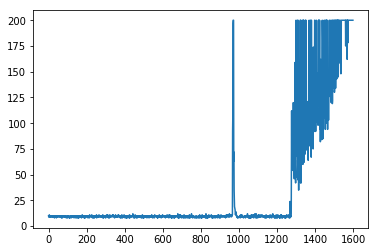

Solved in 1600 steps
Done.


In [28]:
def solve_env(env, agent, max_sessions=2000, t_max=200, solved=190):

    #generate new sessions
    rewards = []
    for i in range(1, max_sessions+1):
        session_reward = train_from_experience(env, agent, t_max)
        rewards.append(session_reward)
        if i % 100 == 0:
            mean_score = np.mean(rewards[-100:])
            clear_output(True)
            print('Step: {}, mean reward: {}'.format(i, mean_score))
            plt.plot(rewards)
            plt.show()
            if mean_score > solved:
                print("Solved in {} steps".format(i))
                break
    return rewards


env = gym.make("CartPole-v0").env
agent = DQNAgent(QNetwork(observation_shape, n_actions))
solve_env(env, agent, t_max=200, solved=190)
print('Done.')

### Lets check how will it work if we require 1000 score to be solved

The question is: Can this agent learn to balance the pole for the longer time?

Step: 1200, mean reward: 361.79


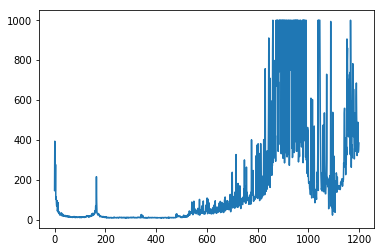

In [ ]:
agent = DQNAgent(QNetwork(observation_shape, n_actions))
solve_env(env, agent, t_max=1000, solved=1000)
print('Done.')

Not really. Looks like in the long term agent unlearns good behaviour.